# Scikit-downscale: an open source Python package for scalable climate downscaling

Joseph Hamman (jhamman@ucar.edu) and Julia Kent (jkent@ucar.edu)

NCAR, United States of America

ECAHM 2020 ID: 143

Climate data from Earth System Models are increasingly being used to study the impacts of climate change on a broad range of biogeophysical (forest fires, fisheries, etc.) and human systems (reservoir operations, urban heat waves, etc.). Before this data can be used to study many of these systems, post-processing steps commonly referred to as bias correction and statistical downscaling must be performed. “Bias correction” is used to correct persistent biases in climate model output and “statistical downscaling” is used to increase the spatiotemporal resolution of the model output (i.e. 1 deg to 1/16th deg grid boxes). For our purposes, we’ll refer to both parts as “downscaling”.

In the past few decades, the applications community has developed a plethora of downscaling methods. Many of these methods are ad-hoc collections of post processing routines while others target very specific applications. The proliferation of downscaling methods has left the climate applications community with an overwhelming body of research to sort through without much in the form of synthesis guilding method selection or applicability.

Motivated by the pressing socio-environmental challenges of climate change – and with the learnings from previous downscaling efforts in mind – we have begun working on a community-centered open framework for climate downscaling: scikit-downscale. We believe that the community will benefit from the presence of a well-designed open source downscaling toolbox with standard interfaces alongside a repository of benchmark data to test and evaluate new and existing downscaling methods.

In this notebook, we provide an overview of the scikit-downscale project, detailing how it can be used to downscale a range of surface climate variables such as air temperature and precipitation. We also highlight how scikit-downscale framework is being used to compare exisiting methods and how it can be extended to support the development of new downscaling methods.


[Insert some sort of figure here, probably showing a “typical” workflow]

## Scikit-downscale
Scikit-downscale is a new Python project we have been compiling over the past few months. In it, we have been building a collection of existing downscaling methods within a common framework. Key features of Scikit-downscale are:

A high-level interface modeled after the popular fit / precict pattern found in many machine learning packages (Scikit-learn, Tensorflow, etc.),
Uses Xarray data structures and utilities for handling multi-dimensional datasets and parrlelization,
Common interface for pointwise and spatial (or global) downscaling models, and
Extensible, allowing the creation of new downscaling methods through composition.
Below is an example implementation of a Scikit-downscale workflow that uses the BCSD method:

from skdownscale.pointwise_models import PointWiseDownscaler
from skdownscale.models.bcsd import BCSDTemperature

```python
# da_temp_train: xarray.DataArray (monthly)
# da_temp_obs: xarray.DataArray (monthly)
# da_temp_obs_daily: xarray.DataArray (daily)
# da_temp_predict: xarray.DataArray (monthly)

# create a model
bcsd_model = PointWiseDownscaler(BCSDTemperature(), dim='time')

# train the model
bcsd_model.train(da_temp_train, da_temp_obs)

# predict with the model  (downscaled_temp: xr.DataArray)
downscaled_temp = bcsd_model.predict(da_temp_predict)
```

## Pointwise Models
We define pointwise methods are those that only use local information during the downscaling process. They can be often represented as a linear model and applied repetively across the entire study domain. Examples of existing pointwise methods are:

- BCSD_[Temperature, Precipitation]: Wood et al 2002
- ARRM: Stoner et al 2012
- (Hybrid) Delta Method
- GARD: https://github.com/NCAR/GARD

Because pointwise methods can be written as a stand-alone linear model, Scikit-downscale implements these models as a Scikit-learn LinearModel or Pipeline. By building directly on Scikit-learn, we inherit a well defined model API and the ability to interoperate with a robust ecosystem utilities for model evaluation and optimization (e.g. grid-search). Perhaps more importantly, this structure also allows us to compare methods at a high-level of granularity (single spatial point) before deploying them on large domain problems.

In the example above, we demonstrated the use of the PointWiseDownscaler. We use this class to wrap a pointwise models allowing training and prediction with multidimensional Xarray objects.

## Example #1 Gard

In [1]:
cd ..

/Users/jkent/Documents/xsd


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import scipy

import numpy as np
import pandas as pd
import xarray as xr

from skdownscale.pointwise_models import PureAnalog, AnalogRegression

In [3]:
# open a small dataset for training
training = xr.open_zarr('data/downscale_test_data.zarr', group='training')
training

<xarray.Dataset>
Dimensions:      (point: 5, time: 13483)
Coordinates:
    lat          (point) float32 dask.array<chunksize=(5,), meta=np.ndarray>
    lon          (point) float32 dask.array<chunksize=(5,), meta=np.ndarray>
  * time         (time) datetime64[ns] 1979-01-01T11:30:00 ... 2015-11-30T11:30:00
Dimensions without coordinates: point
Data variables:
    DIV          (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    PREC_ACC_C   (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    PREC_ACC_NC  (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    PREC_TOT     (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    PSFC         (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    QVAPOR       (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    T            (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    T2           (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    T2max        (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    T2min        (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    T_MEAN       (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    T_RANGE      (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    U            (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    V            (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    W            (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
Attributes:
    NCO:                        "4.5.5"
    history:                    Wed Mar  1 13:48:35 2017: ncatted -a calendar...
    history_of_appended_files:  Wed Feb  8 14:15:52 2017: Appended file wrf_d...
    nco_openmp_thread_number:   1

In [4]:
# open a small dataset of observations (targets)
targets = xr.open_zarr('data/downscale_test_data.zarr', group='targets')
targets

<xarray.Dataset>
Dimensions:  (point: 5, time: 23376)
Coordinates:
    lat      (point) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    lon      (point) float64 dask.array<chunksize=(5,), meta=np.ndarray>
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2013-12-31
Dimensions without coordinates: point
Data variables:
    Prec     (time, point) float32 dask.array<chunksize=(11688, 5), meta=np.ndarray>
    Tmax     (time, point) float32 dask.array<chunksize=(11688, 5), meta=np.ndarray>
    Tmin     (time, point) float32 dask.array<chunksize=(11688, 5), meta=np.ndarray>
    wind     (time, point) float32 dask.array<chunksize=(11688, 5), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 1.6.4 (http://c...
    CDO:                       Climate Data Operators version 1.6.4 (http://c...
    Conventions:               CF-1.4
    NCO:                       4.4.5
    history:                   Fri Oct 10 17:54:37 2014: cdo ifthenelse /Volu...
    nco_openmp_thread_number:  1

In [5]:
# extract 1 point of training data for precipitation and temperature 
X_temp = training.isel(point=0).to_dataframe()[['T2max']] - 273.13
X_pcp = training.isel(point=0).to_dataframe()[['PREC_TOT']] * 24
display(X_temp.head(), X_pcp.head())

,T2max
time,
1979-01-01 11:30:00,-2.337555
1979-01-02 11:30:00,5.119568
1979-01-03 11:30:00,4.024506
1979-01-04 11:30:00,1.282898
1979-01-05 11:30:00,4.978546


,PREC_TOT
time,
1979-01-01 11:30:00,2.486746e-11
1979-01-02 11:30:00,1.179887e-06
1979-01-03 11:30:00,1.755760e-06
1979-01-04 11:30:00,0.000000e+00
1979-01-05 11:30:00,0.000000e+00


In [6]:
# extract 1 point of target data for precipitation and temperature 
y_temp = targets.isel(point=0).to_dataframe()[['Tmax']]
y_pcp = targets.isel(point=0).to_dataframe()[['Prec']]
display(y_temp.head(), y_pcp.head())

,Tmax
time,
1950-01-01,-0.22
1950-01-02,-4.54
1950-01-03,-7.87
1950-01-04,-5.08
1950-01-05,-0.79


,Prec
time,
1950-01-01,5.608394
1950-01-02,2.919726
1950-01-03,3.066762
1950-01-04,4.684164
1950-01-05,4.295568


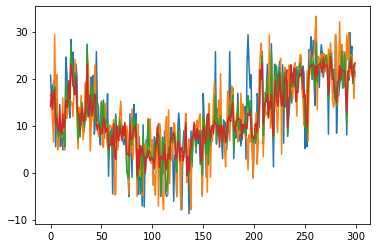

In [7]:
# Fit/predict using the PureAnalog class
for kind in ['best_analog', 'sample_analogs', 'weight_analogs', 'mean_analogs']:
    pure_analog = PureAnalog(kind=kind, n_analogs=10)
    pure_analog.fit(X_temp[:1000], y_temp[:1000])
    out = pure_analog.predict(X_temp[1000:])

    plt.plot(out[:300], label=kind)

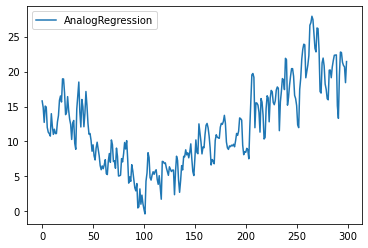

In [8]:
# Fit/predict using the AnalogRegression class
analog_reg = AnalogRegression(n_analogs=100)
analog_reg.fit(X_temp[:1000], y_temp[:1000])
out = analog_reg.predict(X_temp[1000:])
plt.plot(out[:300], label='AnalogRegression')
plt.legend()

## Example #2 bcsd

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import scipy

import numpy as np
import pandas as pd
import xarray as xr

from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation

In [10]:
# utilities for plotting cdfs
def plot_cdf(ax=None, **kwargs):
    if ax:
        plt.sca(ax)
    else:
        ax = plt.gca()
    
    for label, X in kwargs.items():
        vals = np.sort(X, axis=0)
        pp = scipy.stats.mstats.plotting_positions(vals)  
        ax.plot(pp, vals, label=label)
    ax.legend()
    return ax


def plot_cdf_by_month(ax=None, **kwargs):
    fig, axes = plt.subplots(4, 3, sharex=True, sharey=False, figsize=(12, 8))
    
    for label, X in kwargs.items():
        for month, ax in zip(range(1, 13), axes.flat):
            
            vals = np.sort(X[X.index.month == month], axis=0)
            pp = scipy.stats.mstats.plotting_positions(vals)  
            ax.plot(pp, vals, label=label)
            ax.set_title(month)
    ax.legend()
    return ax
    

In [11]:
# open a small dataset for training
training = xr.open_zarr('data/downscale_test_data.zarr', group='training')
training

<xarray.Dataset>
Dimensions:      (point: 5, time: 13483)
Coordinates:
    lat          (point) float32 dask.array<chunksize=(5,), meta=np.ndarray>
    lon          (point) float32 dask.array<chunksize=(5,), meta=np.ndarray>
  * time         (time) datetime64[ns] 1979-01-01T11:30:00 ... 2015-11-30T11:30:00
Dimensions without coordinates: point
Data variables:
    DIV          (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    PREC_ACC_C   (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    PREC_ACC_NC  (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    PREC_TOT     (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    PSFC         (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    QVAPOR       (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    T            (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    T2           (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    T2max        (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    T2min        (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    T_MEAN       (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    T_RANGE      (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    U            (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    V            (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
    W            (point, time) float32 dask.array<chunksize=(3, 13483), meta=np.ndarray>
Attributes:
    NCO:                        "4.5.5"
    history:                    Wed Mar  1 13:48:35 2017: ncatted -a calendar...
    history_of_appended_files:  Wed Feb  8 14:15:52 2017: Appended file wrf_d...
    nco_openmp_thread_number:   1

In [12]:
# open a small dataset of observations (targets)
targets = xr.open_zarr('data/downscale_test_data.zarr', group='targets')
targets

<xarray.Dataset>
Dimensions:  (point: 5, time: 23376)
Coordinates:
    lat      (point) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    lon      (point) float64 dask.array<chunksize=(5,), meta=np.ndarray>
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2013-12-31
Dimensions without coordinates: point
Data variables:
    Prec     (time, point) float32 dask.array<chunksize=(11688, 5), meta=np.ndarray>
    Tmax     (time, point) float32 dask.array<chunksize=(11688, 5), meta=np.ndarray>
    Tmin     (time, point) float32 dask.array<chunksize=(11688, 5), meta=np.ndarray>
    wind     (time, point) float32 dask.array<chunksize=(11688, 5), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 1.6.4 (http://c...
    CDO:                       Climate Data Operators version 1.6.4 (http://c...
    Conventions:               CF-1.4
    NCO:                       4.4.5
    history:                   Fri Oct 10 17:54:37 2014: cdo ifthenelse /Volu...
    nco_openmp_thread_number:  1

In [13]:
# extract 1 point of training data for precipitation and temperature 
X_temp = training.isel(point=0).to_dataframe()[['T2max']].resample('MS').mean() - 273.13
X_pcp = training.isel(point=0).to_dataframe()[['PREC_TOT']].resample('MS').sum() * 24
display(X_temp.head(), X_pcp.head())

,T2max
time,
1979-01-01,3.174133
1979-02-01,5.273163
1979-03-01,13.126129
1979-04-01,13.500275
1979-05-01,20.057251


,PREC_TOT
time,
1979-01-01,102.553276
1979-02-01,216.159973
1979-03-01,98.423416
1979-04-01,129.309418
1979-05-01,41.323780


In [14]:
# extract 1 point of target data for precipitation and temperature 
y_temp = targets.isel(point=0).to_dataframe()[['Tmax']].resample('MS').mean()
y_pcp = targets.isel(point=0).to_dataframe()[['Prec']].resample('MS').sum()
display(y_temp.head(), y_pcp.head())

,Tmax
time,
1950-01-01,-2.065484
1950-02-01,6.638215
1950-03-01,8.544193
1950-04-01,13.238667
1950-05-01,16.199354


,Prec
time,
1950-01-01,214.043198
1950-02-01,237.654190
1950-03-01,269.569855
1950-04-01,149.984604
1950-05-01,65.975349


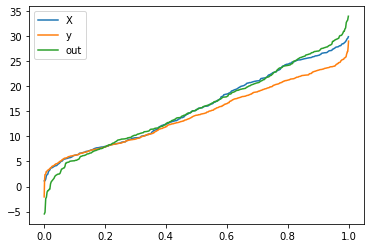

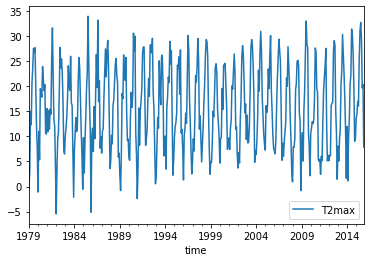

In [15]:
# Fit/predict the BCSD Temperature model
bcsd_temp = BcsdTemperature()
bcsd_temp.fit(X_temp, y_temp)
out = bcsd_temp.predict(X_temp) + X_temp
plot_cdf(X=X_temp, y=y_temp, out=out)
out.plot()

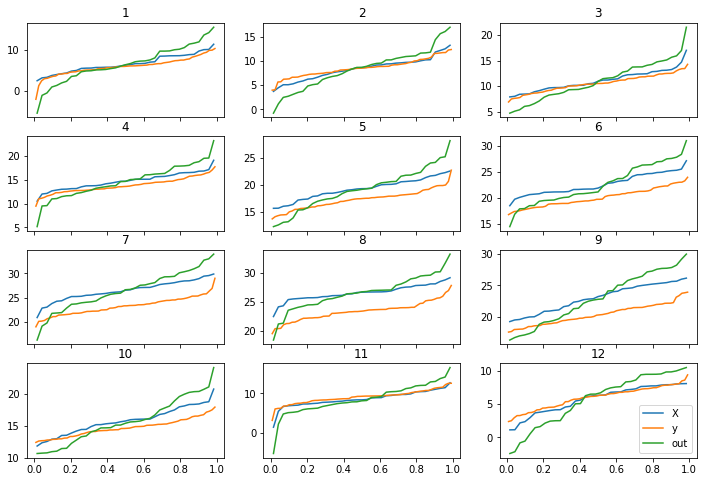

In [16]:
plot_cdf_by_month(X=X_temp, y=y_temp, out=out)

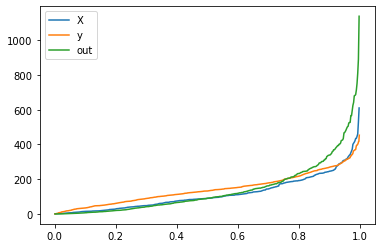

In [17]:
# Fit/predict the BCSD Precipitation model
bcsd_pcp = BcsdPrecipitation()
bcsd_pcp.fit(X_pcp, y_pcp)
out = bcsd_pcp.predict(X_pcp) * X_pcp  
plot_cdf(X=X_pcp, y=y_pcp, out=out)

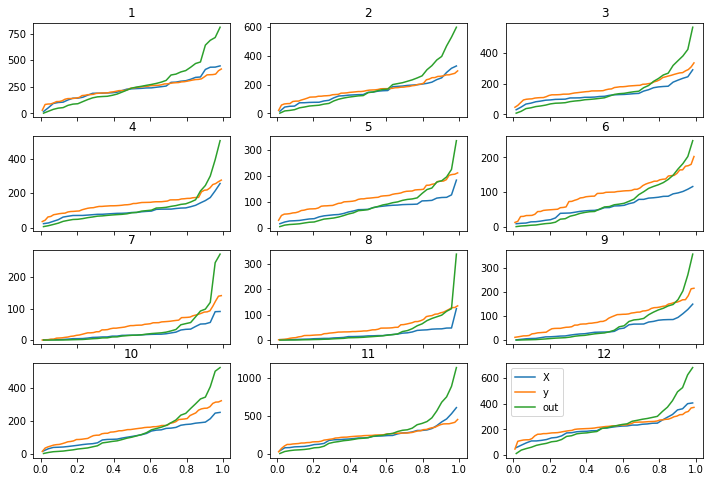

In [18]:
plot_cdf_by_month(X=X_pcp, y=y_pcp, out=out)

## Example #3 Zscore

Z-Score bias correction is a good technique for target variables with Gaussian probability distributions, such as zonal wind speed.

In essence the technique:

1. Finds the mean  
$$\overline{x} = \sum_{i=0}^N \frac{x_i}{N}$$ 
and standard deviation 
$$\sigma = \sqrt{\frac{\sum_{i=0}^N |x_i - \overline{x}|^2}{N-1}}$$ 
of target (measured) data and training (historical modeled) data. 

2. Compares the difference between the statistical values to produce a shift 
$$shift = \overline{x_{target}} - \overline{x_{training}}$$ 
and scale parameter 
$$scale = \sigma_{target} \div \sigma_{training}$$ 

3. Applies these paramaters to the future model data to be corrected to get a new mean
$$\overline{x_{corrected}} = \overline{x_{future}} + shift$$
and new standard deviation
$$\sigma_{corrected} = \sigma_{future} \times scale$$

4. Calculates the corrected values
$$x_{corrected_{i}} = z_i \times \sigma_{corrected} + \overline{x_{corrected}}$$
from the future model's z-score values
$$z_i = \frac{x_i-\overline{x}}{\sigma}$$

In practice, if the wind was on average 3 m/s faster on the first of July in the models compared to the measurements, we would adjust the modeled data for all July 1sts in the future modeled dataset to be 3 m/s faster. And similarly for scaling the standard deviation


In [19]:
%matplotlib inline

import matplotlib.pyplot as plt
import scipy

import numpy as np
import pandas as pd
import xarray as xr

from skdownscale.pointwise_models import ZScoreRegressor

In [20]:
# open a small historical dataset
da_hist = xr.open_dataset('data/uas/uas.hist.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.Colorado.19801990.nc')['uas']
da_hist

<xarray.DataArray 'uas' (time: 3650, lat: 3, lon: 4)>
array([[[-0.374537, -0.399581, -0.749624, -0.835395],
        [ 0.154316, -0.367816, -0.529701, -0.57113 ],
        [ 0.721996,  0.234745,  0.201296,  0.041568]],

       [[ 0.336834, -0.032901,  0.164376,  0.511626],
        [ 0.875419,  0.057952,  0.246745,  0.507216],
        [ 1.277685,  1.039651,  0.989096,  0.69906 ]],

       ...,

       [[ 0.697807,  0.445025,  0.05106 , -0.206735],
        [ 0.761062,  0.546289, -0.029495, -0.236861],
        [ 0.565749,  1.138075,  0.641544,  0.169792]],

       [[ 0.867797,  0.580381,  0.058512, -0.269147],
        [ 0.887389,  0.587695,  0.423439,  0.109003],
        [ 0.813722,  0.794588,  0.869465,  0.492516]]], dtype=float32)
Coordinates:
  * time     (time) object 1980-01-01 12:00:00 ... 1989-12-31 12:00:00
  * lat      (lat) float64 39.75 40.25 40.75
  * lon      (lon) float64 -109.8 -109.2 -108.8 -108.2
Attributes:
    units:          m s-1
    standard_name:  eastward_wind
    actual_range:   [-28.95829057  28.48435832]
    grid_desc:      rotated_pole
    long_name:      Eastward Near-Surface Wind
    cell_methods:   time: mean
    remap:          remapped via ESMF_regrid_with_weights: Higher-order Patch

In [21]:
# open a small measured dataset
da_meas = xr.open_dataset('data/uas/uas.gridMET.NAM-44i.Colorado.19801990.nc')['uas']
da_meas 

<xarray.DataArray 'uas' (time: 3653, lat: 3, lon: 4)>
array([[[-0.358309, -0.130014,  0.22978 ,  0.210967],
        [-0.282695, -0.240967,  0.226679,  0.372505],
        [ 1.961833,  2.358107,  1.127772,  0.254593]],

       [[ 0.680944,  0.609744,  1.6888  ,  2.082545],
        [ 0.341705,  0.486878,  1.910802,  2.24803 ],
        [ 2.022866,  2.792154,  2.694606,  2.238341]],

       ...,

       [[ 1.44994 ,  0.216985,  2.597073,  3.838801],
        [-0.187089, -0.352322,  1.780689,  2.888   ],
        [ 3.355573,  3.610975,  2.612144,  2.206457]],

       [[ 0.023914,  0.021321,  0.035146,  0.042147],
        [ 0.015388,  0.018264,  0.036356,  0.044989],
        [ 0.052141,  0.056727,  0.049951,  0.043119]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01T19:00:00 ... 1989-12-31T19:00:00
  * lon      (lon) float64 -109.8 -109.2 -108.8 -108.2
  * lat      (lat) float64 39.75 40.25 40.75
Attributes:
    missing_threshold:  50%
    cell_methods:       time: mean(interval: 24 hours)
    grid_mapping:       crs
    height:             10 m
    units:              m/s
    standard_name:      eastward_wind
    long_name:          Eastward Surface Wind Speed

In [22]:
# open a small rcp85 dataset
da_rcp85 = xr.open_dataset('data/uas/uas.rcp85.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.Colorado.19902000.nc')['uas']
da_rcp85

<xarray.DataArray 'uas' (time: 3650, lat: 3, lon: 4)>
array([[[0.508362, 0.488494, 0.456749, 0.119222],
        [1.003537, 0.863799, 1.106053, 0.873307],
        [1.051252, 0.68797 , 1.091466, 1.168896]],

       [[0.843134, 0.595563, 0.565024, 0.587312],
        [1.051339, 0.354742, 0.52908 , 0.910744],
        [1.217433, 0.952386, 0.945628, 1.059983]],

       ...,

       [[2.695519, 2.540047, 2.468408, 2.169297],
        [3.093721, 2.244844, 2.38001 , 2.725029],
        [2.430926, 2.671634, 3.139106, 3.208023]],

       [[0.903165, 0.567992, 0.39651 , 0.623385],
        [0.773778, 0.32563 , 0.264852, 0.629858],
        [0.188079, 0.347713, 0.499321, 0.733001]]], dtype=float32)
Coordinates:
  * time     (time) object 1990-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat      (lat) float64 39.75 40.25 40.75
  * lon      (lon) float64 -109.8 -109.2 -108.8 -108.2
Attributes:
    units:          m s-1
    standard_name:  eastward_wind
    actual_range:   [-28.95829057  28.48435832]
    grid_desc:      rotated_pole
    long_name:      Eastward Near-Surface Wind
    cell_methods:   time: mean
    remap:          remapped via ESMF_regrid_with_weights: Higher-order Patch

In [23]:
# select one point from each dataset
training = da_hist.sel(lat=40.25, lon=-109.2, method='nearest').squeeze().to_dataframe()[['uas']]
training

,uas
time,
1980-01-01 12:00:00,-0.367816
1980-01-02 12:00:00,0.057952
1980-01-03 12:00:00,0.049503
1980-01-04 12:00:00,0.250687
1980-01-05 12:00:00,0.539990
...,...
1989-12-27 12:00:00,0.434693
1989-12-28 12:00:00,-1.299077
1989-12-29 12:00:00,-0.004788


In [24]:

target = da_meas.sel(lat=40.25, lon=-109.2, method='nearest').squeeze().to_dataframe()[['uas']]
target

,uas
time,
1980-01-01 19:00:00,-0.240967
1980-01-02 19:00:00,0.486878
1980-01-03 19:00:00,0.000394
1980-01-04 19:00:00,-0.420946
1980-01-05 19:00:00,0.175797
...,...
1989-12-27 19:00:00,-0.107278
1989-12-28 19:00:00,-0.181846
1989-12-29 19:00:00,0.295216


In [25]:
future = da_rcp85.sel(lat=40.25, lon=-109.2, method='nearest').squeeze().to_dataframe()[['uas']]
future

,uas
time,
1990-01-01 12:00:00,0.863799
1990-01-02 12:00:00,0.354742
1990-01-03 12:00:00,3.573094
1990-01-04 12:00:00,1.034904
1990-01-05 12:00:00,0.919578
...,...
1999-12-27 12:00:00,2.066864
1999-12-28 12:00:00,1.002796
1999-12-29 12:00:00,0.799936


In [26]:
# bias correction using ZScoreRegresssor
zscore = ZScoreRegressor()
hist_stats = zscore.fit(training, target)
out, fut_stats = zscore.predict(future)

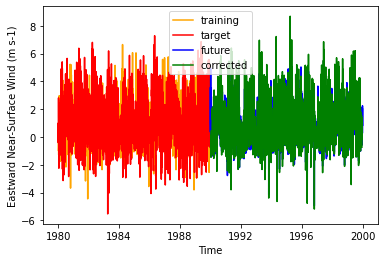

In [27]:
# visualize the datasets
time_target = pd.date_range('1980-01-01','1989-12-31', freq='D')
time_training = time_target[~((time_target.month==2) & (time_target.day==29))]
time_future = pd.date_range('1990-01-01','1999-12-31', freq='D')
time_future = time_future[~((time_future.month==2) & (time_future.day==29))]

plt.figure()
plt.plot(time_training,training.uas, 'orange', label='training')
plt.plot(time_target,target.uas, 'red', label='target')

plt.plot(time_future,future.uas, 'blue', label='future')
plt.plot(time_future,out.uas, 'green', label='corrected')


plt.xlabel('Time')
plt.ylabel('Eastward Near-Surface Wind (m s-1)')
plt.legend();

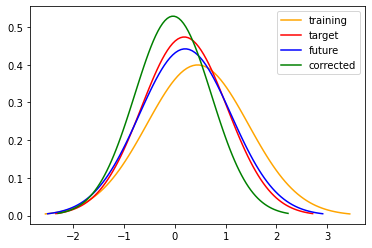

In [28]:
# visualize the zscore correction
def gaus(mean, std, doy):
    mu = mean[doy]
    sigma = std[doy]

    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = scipy.stats.norm.pdf(x, mu, sigma)
    return x, y

training_mean = hist_stats.stats_dict_['X_mean']
training_std = hist_stats.stats_dict_['X_std']
target_mean = hist_stats.stats_dict_['y_mean']
target_std = hist_stats.stats_dict_['y_std']

future_mean = fut_stats['meani']
future_mean = future_mean.groupby(future_mean.index.dayofyear).mean()
future_std = fut_stats['stdi']
future_std = future_std.groupby(future_std.index.dayofyear).mean()
corrected_mean = fut_stats['meanf']
corrected_mean = corrected_mean.groupby(corrected_mean.index.dayofyear).mean()
corrected_std = fut_stats['stdf']
corrected_std = corrected_std.groupby(corrected_std.index.dayofyear).mean()

doy=20
plt.figure()
x,y = gaus(training_mean, training_std, doy)
plt.plot(x, y, 'orange', label = 'training')
x,y = gaus(target_mean, target_std, doy)
plt.plot(x, y, 'red', label = 'target')
x,y = gaus(future_mean, future_std, doy)
plt.plot(x, y, 'blue', label = 'future')
x,y = gaus(corrected_mean, corrected_std, doy)
plt.plot(x, y, 'green', label = 'corrected')
plt.legend();

## Wrapper

## Spatial Models
Spatial models is a second class of downscaling methods that use information from the full study domain to form relationships between observations and ESM data. Scikit-downscale implements these models as as SpatialDownscaler. Beyond providing fit and predict methods that accept Xarray objects, the internal layout of these methods is intentionally unspecified. We are currently working on wrapping a few popular spatial downscaling models such as:

- MACA
- LOCA

## Benchmark Applications
Its likely that one of the reasons we haven’t seen strong consensus develop around particularl downscaling methodologies is the abscense of widely available benchamrk applications to test methods against eachother. We haven’t solved this problem but we are motivated to work accross the community to develop a new benchmark applications.

Data

Metrics

## Call for Participation
This effort is just getting started. With the recent release of CMIP6, we expect a surge of interest in downscaled climate data. There are clear opportunities for involvement from climate impacts practicioneers, computer scientists with an interest in machine learning for climate applications, and climate scientists alike. Please reach out if you are interested in participating in any way.